<a href="https://www.kaggle.com/code/mohammadalisafadoost/car-price-prediction-with-linearregression?scriptVersionId=194560197" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style = "text-align:center; font-family:courier; font-size:300%; color:yellow ; border: 1px solid; padding: 40px;" >
    <em>Car price prediction with LinearRegression</em>
</h1>

<hr style = " border-top: 2px solid purple; " />

<h4 style = " font-family:courier; color:yellow ; " >
<p>
    In this notebook we are going to use Linear Regression for predicting car price .
</p>
<p>
    Lets read our dataset and do some analize on it .
</p>
</h4>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew,kurtosis
from sklearn.preprocessing import PowerTransformer,QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import r2_score,mean_squared_error
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read dataset
data = pd.read_csv('/kaggle/input/cardata/cardata.csv')
df = data.copy()

In [3]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [6]:
df[['Car_Name','Fuel_Type','Seller_Type','Transmission']].describe()

,Car_Name,Fuel_Type,Seller_Type,Transmission
count,301,301,301,301
unique,98,3,2,2
top,city,Petrol,Dealer,Manual
freq,26,239,195,261


<hr style = " border-top: 2px solid purple; " />

Text(0.5, 0, 'Kms_Driven')

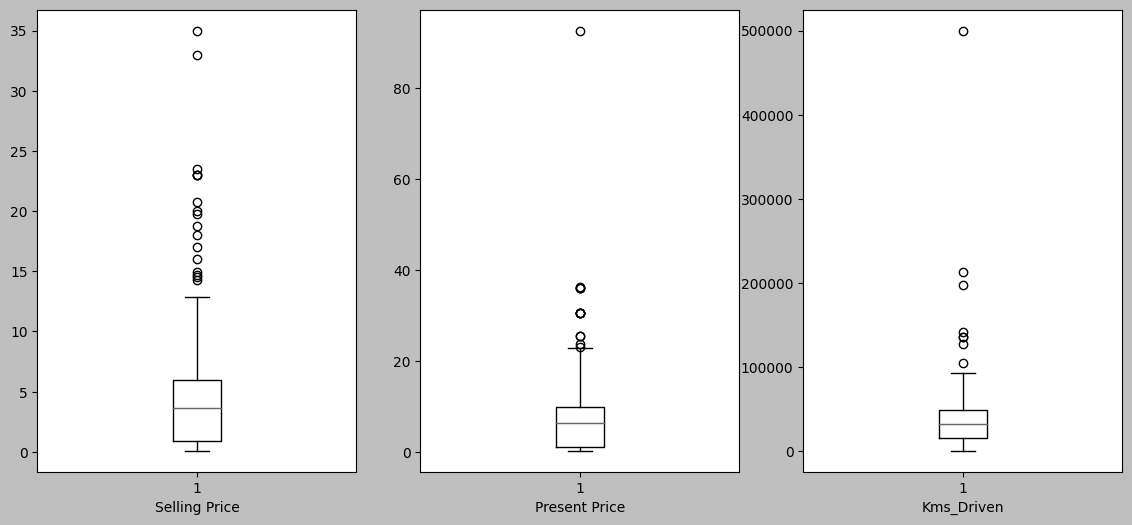

In [7]:
# boxplot for Selling_Price , Present_Price and Kms_Driven column
plt.style.use('grayscale')
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.boxplot(df.Selling_Price)
plt.xlabel('Selling Price')
plt.subplot(1,3,2)
plt.boxplot(df.Present_Price)
plt.xlabel('Present Price')
plt.subplot(1,3,3)
plt.boxplot(df.Kms_Driven)
plt.xlabel('Kms_Driven')
#fivethirtyeight

<h4 style = " font-family:courier; color:yellow ; " >
<p>
    As you can see in the box plots, there are some outliers in our data, but since the number of samples in our data set is small, let's just remove critical outliers.
</p>
</h4>

In [8]:
# Removing outliers
df = df[(df.Present_Price < 60) & (df.Kms_Driven < 300000)]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       299 non-null    object 
 1   Year           299 non-null    int64  
 2   Selling_Price  299 non-null    float64
 3   Present_Price  299 non-null    float64
 4   Kms_Driven     299 non-null    int64  
 5   Fuel_Type      299 non-null    object 
 6   Seller_Type    299 non-null    object 
 7   Transmission   299 non-null    object 
 8   Owner          299 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 23.4+ KB


<Axes: >

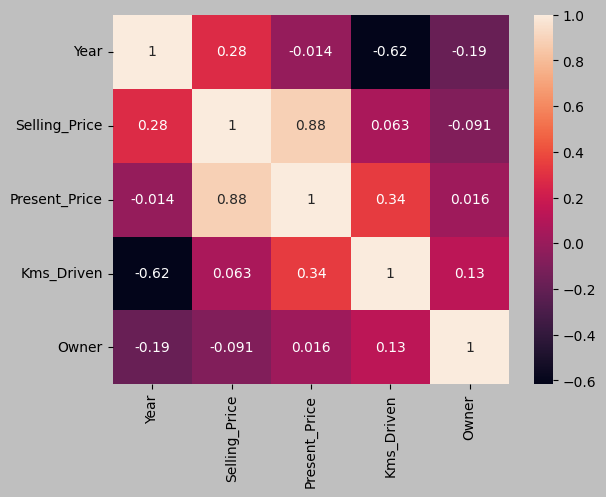

In [10]:
# Heatmap for numeric columns
df_corr = df.corr(numeric_only=True)
sns.heatmap(df_corr,annot=True)

<h4 style = " font-family:courier; color:yellow ; " >
<p>
    Highest correlation with target(Selling Price) belong to Present Price column and definitely this column will have a great impact on Linear Regression model predictions.
</p>
<p>
    Let's see different data distributions for Present Price column and improve its correlation with target if possible.
</p>
</h4>

In [11]:
box_cox_transformer = PowerTransformer(method='box-cox')
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')
normal_quantile_transformer = QuantileTransformer(n_quantiles=298,output_distribution="normal")
uniform_quantile_transformer = QuantileTransformer(n_quantiles=298,output_distribution="uniform")

In [12]:
# Function to plot different distributions
def distribution_plot(data):
    plt.figure(figsize=(14,12))
    plt.subplot(331)
    plt.hist(data,bins=30)
    plt.xlabel('Original data')
    plt.subplot(332)
    plt.hist(np.log(data),bins=30)
    plt.xlabel('Logaritmic data')
    plt.subplot(333)
    plt.hist(np.sqrt(data),bins=30)
    plt.xlabel('Square root data')
    plt.subplot(334)
    plt.hist(np.sin(data),bins=30)
    plt.xlabel('Sinus data')
    plt.subplot(335)
    plt.hist(np.cos(data),bins=30)
    plt.xlabel('Cosinus data')
    plt.subplot(336)
    plt.hist(box_cox_transformer.fit_transform(data),bins=30)
    plt.xlabel('Box_Cox data')
    plt.subplot(337)
    plt.hist(yeo_johnson_transformer.fit_transform(data),bins=30)
    plt.xlabel('Yeo-Johnson data')
    plt.subplot(338)
    plt.hist(normal_quantile_transformer.fit_transform(data),bins=30)
    plt.xlabel('normal quantile data')
    plt.subplot(339)
    plt.hist(uniform_quantile_transformer.fit_transform(data),bins=30)
    plt.xlabel('uniform quantile data')

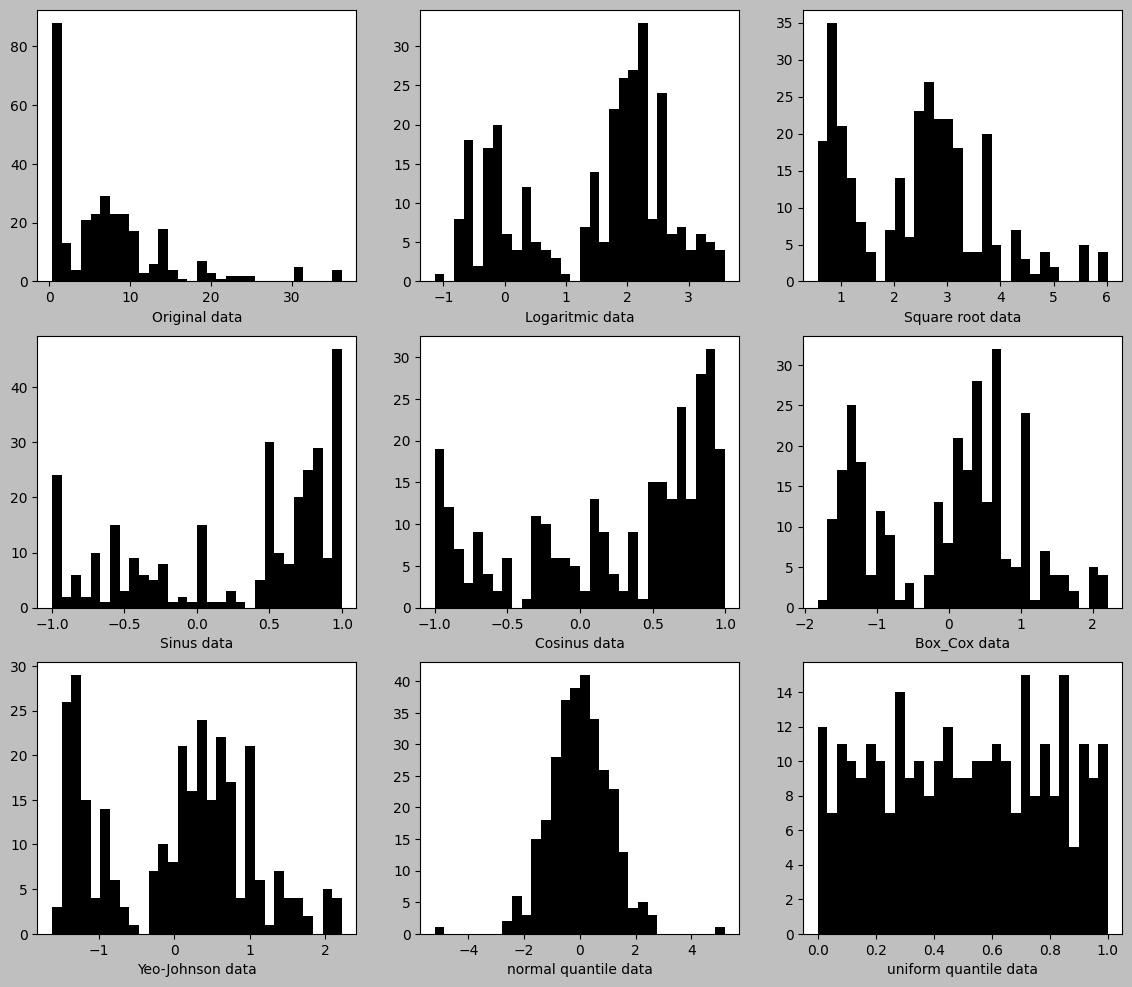

In [13]:
distribution_plot(df[['Present_Price']])

<h4 style = " font-family:courier; color:yellow ; " >
<p>
    Above histogram plots shows different data distributions for Present Price column.
</p>
</h4>

In [14]:
# Function to make different distributions for one feature
def new_features_corr(col,target = 'Selling_Price'):
    df_corr = df[[target,col]]
    df_corr.loc[:,'Normal_Quantile_'+ col] = normal_quantile_transformer.fit_transform(df_corr[[col]])
    df_corr.loc[:,'Uniform_Quantile_'+ col] = uniform_quantile_transformer.fit_transform(df_corr[[col]])
    df_corr.loc[:,'Box_Cox_'+ col] = box_cox_transformer.fit_transform(df_corr[[col]])
    df_corr.loc[:,'Yeo_Johnson_'+ col] = yeo_johnson_transformer.fit_transform(df_corr[[col]])
    for row in df_corr.index:
        df_corr.loc[row,'Log_'+ col] = np.log(df_corr.loc[row,col])
        df_corr.loc[row,'Sqrt_'+ col] = np.sqrt(df_corr.loc[row,col])
        df_corr.loc[row,'Sin_'+ col] = np.sin(df_corr.loc[row,col])
        df_corr.loc[row,'Cos_'+ col] = np.cos(df_corr.loc[row,col])
        df_corr.loc[row,'Power_Two_'+ col] = (df_corr.loc[row,col] ** 2)
        df_corr.loc[row,'Power_Three_'+ col] = (df_corr.loc[row,col] ** 3)
    plt.figure(figsize=(14,2))
    sns.heatmap(df_corr.corr()[:1],annot=True)
    plt.show()

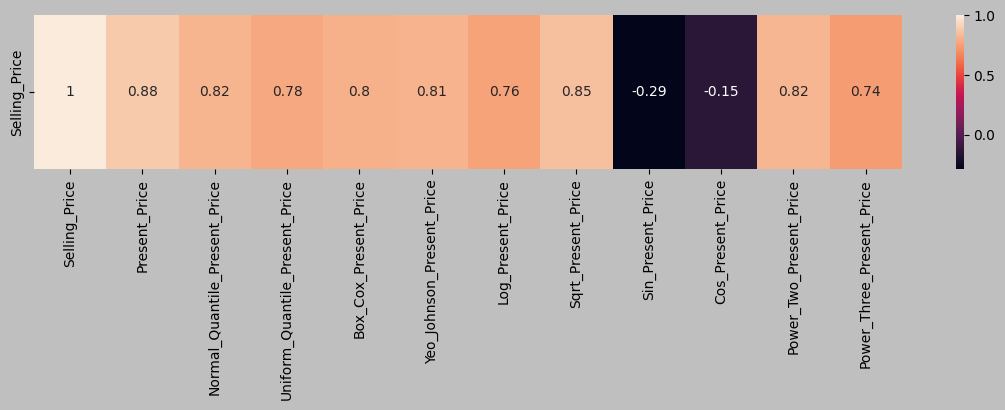

In [15]:
new_features_corr(col = 'Present_Price')

<h4 style = " font-family:courier; color:yellow ; " >
<p>
    As you can see original Present Price column data has highest correlation with target, so let's don't transform it. 
</p>
<p>
    For now let's keep original Kms_Driven column and go for categorical columns.
</p>
</h4>

In [16]:
final_df = df[['Selling_Price','Present_Price','Kms_Driven']]

In [17]:
df.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner'],
      dtype='object')

In [18]:
df.groupby('Fuel_Type')['Selling_Price'].agg(['mean','max','min','std','count'])

,mean,max,min,std,count
Fuel_Type,,,,,
CNG,3.100000,3.25,2.95,0.212132,2
Diesel,9.859492,33.00,3.10,6.465363,59
Petrol,3.277185,19.75,0.10,3.135683,238


<h4 style = " font-family:courier; color:yellow ; " >
<p>
    Fuel_Type column show that most of cars in this data are petrol cars and diesel cars have higher price than petrol cars and cng cars.
</p>

</h4>

In [19]:
df.groupby('Seller_Type')['Selling_Price'].agg(['mean','max','min','std','count'])

,mean,max,min,std,count
Seller_Type,,,,,
Dealer,6.575928,33.0,1.05,4.727726,194
Individual,0.877619,16.0,0.10,1.645781,105


<h4 style = " font-family:courier; color:yellow ; " >
<p>
    Seller_Type column show that cars sold by dealers had higher price than cars sold by individuals.
</p>
</h4>

In [20]:
df.groupby('Transmission')['Selling_Price'].agg(['mean','max','min','std','count'])

,mean,max,min,std,count
Transmission,,,,,
Automatic,9.657179,33.0,0.25,8.746769,39
Manual,3.812500,17.0,0.10,3.253714,260


<h4 style = " font-family:courier; color:yellow ; " >
<p>
    Transmission column show that most of cars in data are manual cars and automatic cars had higher price than manual cars.
</p>
</h4>

In [21]:
df.groupby('Owner')['Selling_Price'].agg(['mean','max','min','std','count'])

,mean,max,min,std,count
Owner,,,,,
0,4.6725,33.00,0.10,4.828786,288
1,1.9700,5.25,0.15,2.126970,10
3,2.5000,2.50,2.50,NaN,1


<h4 style = " font-family:courier; color:yellow ; " >
<p>
    Owner column show that most of cars in data doesn't have any owner before.
</p>
</h4>

In [22]:
categorical_columns = ['Fuel_Type','Seller_Type','Transmission']
# Create a new column for each unique value in the categorical columns.
df_categorical = pd.get_dummies(
    data = df ,
    prefix = 'OHE' ,
    prefix_sep = '_' ,
    columns = categorical_columns ,
    drop_first = True ,
    dtype = 'int8'
)

In [23]:
df_categorical.drop(['Car_Name','Year','Present_Price','Kms_Driven'],axis=1,inplace=True)

<Axes: >

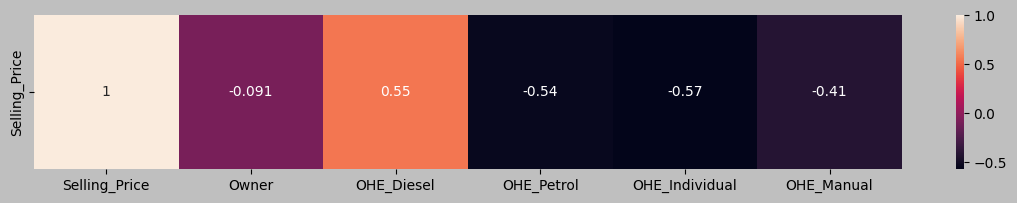

In [24]:
plt.figure(figsize=(14,2))
sns.heatmap(df_categorical.corr()[:1],annot=True)

<h4 style = " font-family:courier; color:yellow ; " >
<p>
    In the above heatmap you can see correlation of categorical columns with target after making them ready for model training .
</p>
</h4>

In [25]:
df_categorical.drop('Selling_Price',axis=1,inplace=True)
final_df = final_df.join(df_categorical)

In [26]:
df_year = df[['Selling_Price','Year']]

<Axes: >

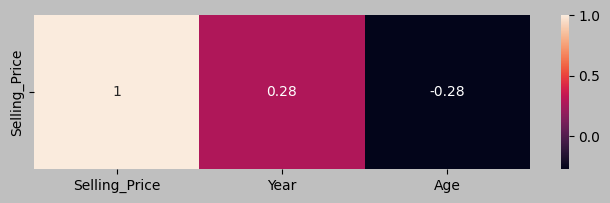

In [27]:
df_year['Age'] = datetime.now().year - df_year['Year']
plt.figure(figsize=(8,2))
sns.heatmap(df_year.corr()[:1],annot=True)

<h4 style = " font-family:courier; color:yellow ; " >
<p>
    In the above heatmap you can see correlation of Year column and a new column named Age created by lowering current year from year in dataset, we are going to just keep Age column.
</p>
<p>
    Now let's train the model and check the score using cross validation.
</p>
</h4>

In [28]:
final_df = final_df.join(df_year.Age)

In [29]:
final_df.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,OHE_Diesel,OHE_Petrol,OHE_Individual,OHE_Manual,Age
0,3.35,5.59,27000,0,0,1,0,1,10
1,4.75,9.54,43000,0,1,0,0,1,11
2,7.25,9.85,6900,0,0,1,0,1,7
3,2.85,4.15,5200,0,0,1,0,1,13
4,4.60,6.87,42450,0,1,0,0,1,10


<hr style = " border-top: 2px solid purple; " />

In [30]:
X = final_df.drop('Selling_Price',axis=1)
y = final_df.Selling_Price

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1,test_size=0.1)

In [32]:
model = LinearRegression()

In [33]:
kfold_cv = KFold(10,shuffle=True,random_state=1)
np.mean(cross_val_score(model,X_train,y_train,cv=kfold_cv))

0.8224375449023876

<hr style = " border-top: 2px solid purple; " />

<h4 style = " font-family:courier; color:yellow ; " >
<p>
    Let's create new features using continuous data columns to increase model score.
</p>
</h4>

<Axes: >

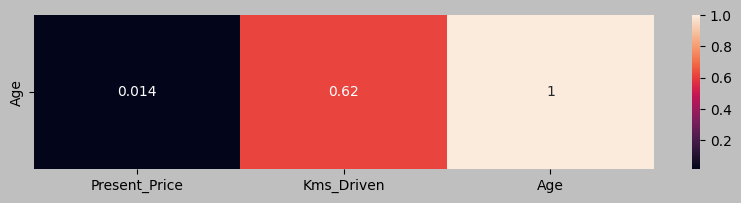

In [34]:
plt.figure(figsize=(10,2))
sns.heatmap(final_df[['Present_Price','Kms_Driven','Age']].corr()[2:],annot=True)

In [35]:
df_new_feature = final_df[['Selling_Price','Present_Price','Age']]

In [36]:
df_new_feature['Present_Price/year'] = df_new_feature.Present_Price / df_new_feature.Age
df_new_feature['Present_Price*year'] = df_new_feature.Present_Price * df_new_feature.Age

<Axes: >

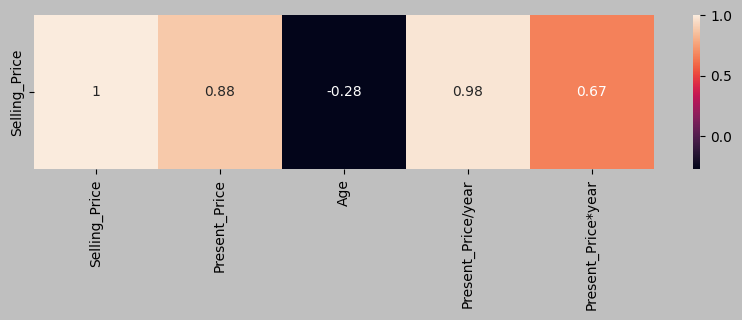

In [37]:
plt.figure(figsize=(10,2))
sns.heatmap(df_new_feature.corr()[:1],annot=True)

<h4 style = " font-family:courier; color:yellow ; " >
<p>
The Present Price column was more important than the Kms_Driven column and had a lower correlation with the Age column, so it was a suitable column to mix with the Age column because mixing columns that have a high correlation may cause overfitting of the model, and after mixing the current price column with the column Age I found that dividing the current price by age produces a highly correlated feature.
</p>
</h4>

In [38]:
final_df = final_df.join(df_new_feature['Present_Price/year'])

In [39]:
#scaler = MinMaxScaler()
#final_df.Present_Price = scaler.fit_transform(final_df[['Present_Price']])
#final_df.Kms_Driven = scaler.fit_transform(final_df[['Kms_Driven']])
#final_df.Age = scaler.fit_transform(final_df[['Age']])
#final_df['Present_Price/year'] = scaler.fit_transform(final_df[['Present_Price/year']])

In [40]:
final_df

,Selling_Price,Present_Price,Kms_Driven,Owner,OHE_Diesel,OHE_Petrol,OHE_Individual,OHE_Manual,Age,Present_Price/year
0,3.35,5.59,27000,0,0,1,0,1,10,0.559000
1,4.75,9.54,43000,0,1,0,0,1,11,0.867273
2,7.25,9.85,6900,0,0,1,0,1,7,1.407143
3,2.85,4.15,5200,0,0,1,0,1,13,0.319231
4,4.60,6.87,42450,0,1,0,0,1,10,0.687000
...,...,...,...,...,...,...,...,...,...,...
296,9.50,11.60,33988,0,1,0,0,1,8,1.450000
297,4.00,5.90,60000,0,0,1,0,1,9,0.655556
298,3.35,11.00,87934,0,0,1,0,1,15,0.733333
299,11.50,12.50,9000,0,1,0,0,1,7,1.785714


<hr style = " border-top: 2px solid purple; " />

In [41]:
X = final_df.drop('Selling_Price',axis=1)
y = final_df.Selling_Price

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1,test_size=0.1)

In [43]:
model = LinearRegression()

In [44]:
from sklearn.model_selection import cross_val_score,KFold

In [45]:
kfold_cv = KFold(10,shuffle=True,random_state=1)
np.mean(cross_val_score(model,X_train,y_train,cv=kfold_cv))

0.9624688010332344

In [46]:
np.mean(cross_val_score(model,X,y,cv=kfold_cv))

0.9690321666300085

In [47]:
model.fit(X_train,y_train)

LinearRegression()

In [48]:
y_pred = model.predict(X_test)

In [49]:
r2_score(y_test,y_pred)

0.9806119540708513

In [50]:
mean_squared_error(y_test,y_pred)

0.519167113755689

In [51]:
X.columns

Index(['Present_Price', 'Kms_Driven', 'Owner', 'OHE_Diesel', 'OHE_Petrol',
       'OHE_Individual', 'OHE_Manual', 'Age', 'Present_Price/year'],
      dtype='object')

In [52]:
model.coef_

array([-2.81562528e-01, -4.60163265e-06, -3.06495169e-01,  1.41415865e+00,
        1.72575943e-01, -4.44948095e-01, -2.88621023e-01,  4.81635389e-02,
        7.96601615e+00])

In [53]:
model.intercept_

0.2790179511937305

<h4 style = " font-family:courier; color:yellow ; " >
<p>
    final score for this model is 98 percent that is a good R2 Score and mean squared error is also low, Coefficients of features also shows that all features has a high impact on final model accuracy. 
</p>
</h4>

<hr style = " border-top: 2px solid purple; " />

In [54]:
check_y = pd.DataFrame(y_test)
check_y.insert(loc=1,column='Prediction',value=y_pred)
check_y

,Selling_Price,Prediction
174,0.38,0.408430
289,10.11,10.210732
51,23.00,20.417260
147,0.55,0.391584
216,2.90,3.654620
199,0.12,0.401394
276,8.65,8.690609
62,18.75,20.336690
27,6.00,5.538917
203,2.95,2.066652


Text(0.5, 1.0, 'actual price vs predicted price')

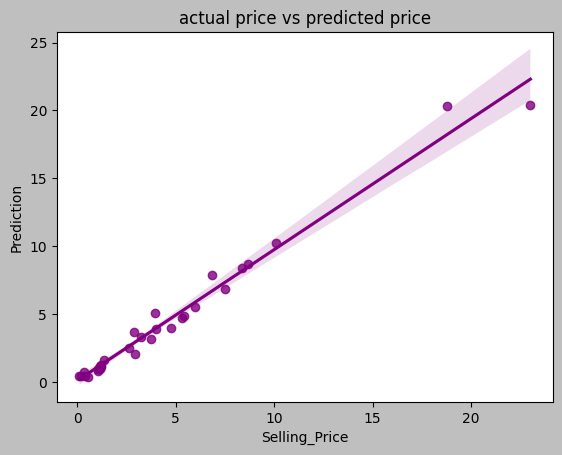

In [55]:
sns.regplot(x=check_y['Selling_Price'],y=check_y['Prediction'],color='purple')
plt.title('actual price vs predicted price')

<h4 style = " font-family:courier; color:yellow ; " >
<p>
    45 degree slope between real price and predicted price shows us that our model works well.
</p>
</h4>

Text(0.5, 1.0, 'diffrent between real price and predicted price vs present price')

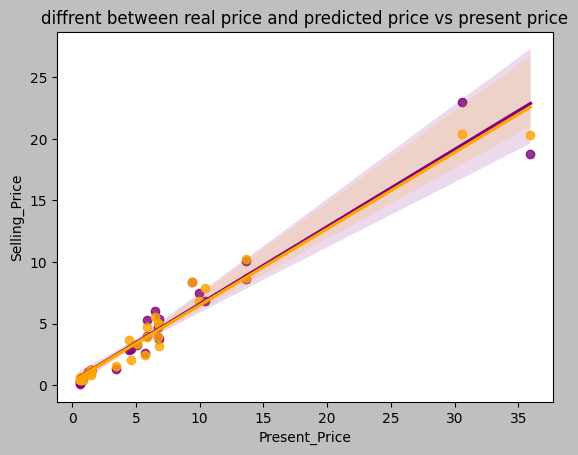

In [56]:
sns.regplot(x=X_test['Present_Price'],y=y_test,color='purple')
sns.regplot(x=X_test['Present_Price'],y=y_pred,color='orange')
plt.title('diffrent between real price and predicted price vs present price')

<h4 style = " font-family:courier; color:yellow ; " >
<p>
    Purple is real price and orange is predicted price as you can see the accuracy goes down at higher prices and I think it's because the higher priced samples are much lower than the lower priced ones.
</p>
</h4>